# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:5]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [15]:
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lr,
    rf
]

In [16]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [17]:
from src.models.classifiers import StackedGeneralizationClassifier

In [28]:
sg = StackedGeneralizationClassifier(base_clfs = base_clfs, meta_clf = LogisticRegression(), verbose=False)

sg.cv_outer_loop(all_hyper_parameters = all_hyper_parameters, X = X_train, y = y_train, refit=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop, each loop:
	Number of 0's: ~977 (94.18%)
	Number of 1's: ~60 (5.82%)


In [19]:
y_test_pred_con, y_test_pred_cut = sg.predict(X_test)

In [20]:
from sklearn.metrics import roc_auc_score

In [21]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out continous model: 0.9560559535994541'

In [22]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out continous model: 0.8900503241214603'

In [23]:
from src.visualization.visualize import plot_roc, plot_precision_recall

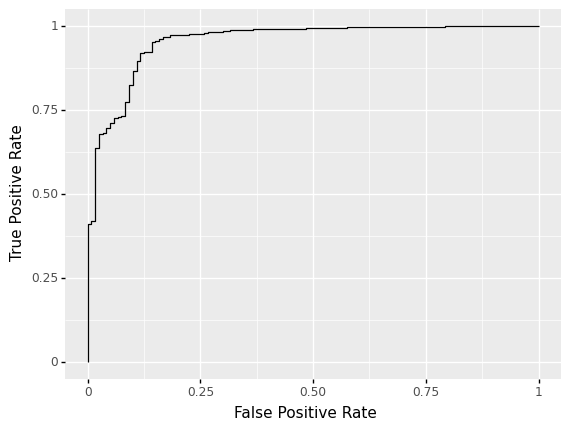

<ggplot: (360020986)>

In [24]:
plot_roc(y_test, y_test_pred_con)

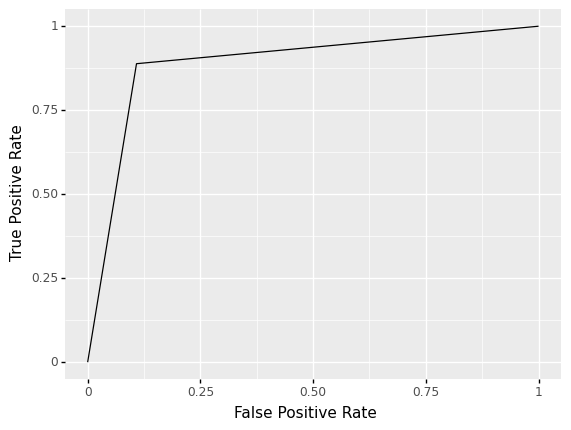

<ggplot: (360118263)>

In [25]:
plot_roc(y_test, y_test_pred_cut)

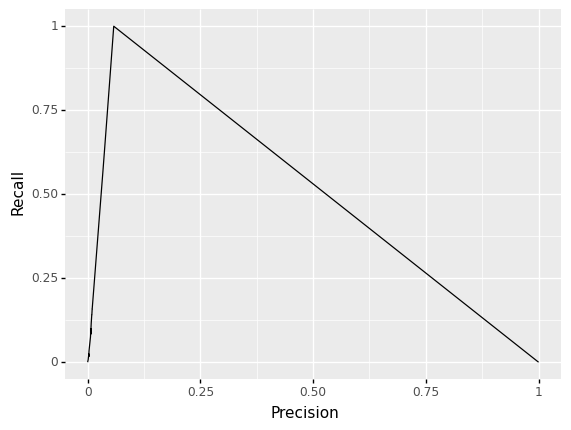

<ggplot: (377502687)>

In [26]:
plot_precision_recall(y_test, y_test_pred_con)